# Эмбеддинг на базе Bert Transformer

BERT (Bidirectional Encoder Representations from Transformers) - одна из наиболее известных и успешных моделей обработки естественного языка, основанная на архитектуре Трансформер.

Перед запуском ноутбука запустите **MLflow Server** в консоли:

`mlflow server --host 127.0.0.1 --port 8080`

In [1]:
# Путь до корневой папки проекта _относительно папки запуска этого скрипта_
import os

ABSOLUTE_PATH = os.path.abspath("../../")

In [2]:
# Параметры для данного ноутбука (не нужны в общем конфиге)
TASK_NAME       = "Bert Embeddings"
EXPERIMENT_NAME = "Embedding_50K_v2"
RUN_NAME        = "bert_embeddings"     # Часть пути, без пробелов и спецсимволов!

Загружаем параметры из файла конфигурации

In [3]:
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

GlobalHydra.instance().clear()

# Hydra context initialization
initialize(version_base=None, config_path=".", job_name=TASK_NAME)
cfg = compose(config_name="config")

# print(OmegaConf.to_yaml(cfg))

Загружаем датасет

In [4]:
import os
import polars as pl

data = pl.read_csv(
    os.path.join(ABSOLUTE_PATH, cfg.paths.data, cfg.files.train_data),
    has_header=False,
    new_columns=["Polarity", "Title", "Review"],
    n_rows=cfg.params.nrows,
)

pl.Config.set_fmt_str_lengths(100)
data.head(3)

shape: (3, 3)
┌──────────┬───────────────────────────────────────┬───────────────────────────────────────────────┐
│ Polarity ┆ Title                                 ┆ Review                                        │
│ ---      ┆ ---                                   ┆ ---                                           │
│ i64      ┆ str                                   ┆ str                                           │
╞══════════╪═══════════════════════════════════════╪═══════════════════════════════════════════════╡
│ 2        ┆ Stuning even for the non-gamer        ┆ This sound track was beautiful! It paints the │
│          ┆                                       ┆ senery in your mind so well I would recomend  │
│          ┆                                       ┆ it even t…                                    │
│ 2        ┆ The best soundtrack ever to anything. ┆ I'm reading a lot of reviews saying that this │
│          ┆                                       ┆ is the best 'game soundtrack' and I figured   │
│          ┆                                       ┆ that I'd w…                                   │
│ 2        ┆ Amazing!                              ┆ This soundtrack is my favorite music of all   │
│          ┆                                       ┆ time, hands down. The intense sadness of      │
│          ┆                                       ┆ "Prisoners of F…                              │
└──────────┴───────────────────────────────────────┴───────────────────────────────────────────────┘

Проверяем, что датасет сбалансирован по отзывам

In [5]:
data = data.select('Polarity', 'Review').with_columns(
    pl.col("Polarity").map_elements(
        lambda polarity: "Negative" if polarity == 1 else "Positive"
    )
)

data['Polarity'].value_counts()

/tmp/ipykernel_4273/3547166247.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  data = data.select('Polarity', 'Review').with_columns(


shape: (2, 2)
┌──────────┬───────┐
│ Polarity ┆ count │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ Negative ┆ 24494 │
│ Positive ┆ 25506 │
└──────────┴───────┘

Разбиваем на тренировочную и тестовую выборки

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    data,
    test_size=cfg.params.test_size,
    shuffle=cfg.params.shuffle,
    random_state=cfg.params.random_state,

)

Загружаем Bert модель и его токенайзер

In [7]:
import torch
from transformers import AutoTokenizer, AutoModel

model_name = "bert-base-uncased"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
# Проверим наличие графического процессора
device

device(type='cuda')

Загружаем батчами во избежание переполнения памяти

In [9]:
from torch.utils.data import DataLoader

fixed_batch_size = 128
train_dataloader = DataLoader(
    train["Review"].to_list(), batch_size=fixed_batch_size, shuffle=False
)
test_dataloader = DataLoader(
    test["Review"].to_list(), batch_size=fixed_batch_size, shuffle=False
)

Инференс получаем как выход с последнего слоя берта:

In [10]:
def batch_inference(batch):
    tokenized_batch = tokenizer(
        batch, padding=True, 
        truncation=True, 
        return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        hidden_batch = bert_model(**tokenized_batch)
        batch_embeddings = hidden_batch.last_hidden_state[:, 0 ,:].detach().to("cpu")
        return batch_embeddings

train_embeddings = torch.concat(
    [batch_inference(batch_data) for batch_data in train_dataloader]
)
test_embeddings = torch.concat(
    [batch_inference(batch_data) for batch_data in test_dataloader]
)

Вспомогательный код для отрисовки Confusion матрицы

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from sklearn.metrics import (
    ConfusionMatrixDisplay,
)

def conf_matrix(y_true: np.ndarray, pred: np.ndarray) -> Figure:
    plt.ioff()
    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(y_true, pred, ax=ax, colorbar=False)
    ax.xaxis.set_tick_params(rotation=90)
    _ = ax.set_title(f"Confusion Matrix")
    plt.tight_layout()
    return fig

Используем **MLflow** для логирования результатов обучения логистической регрессии

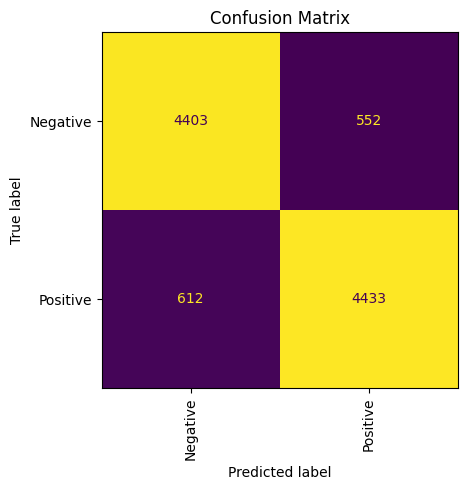

In [12]:
import mlflow
from sklearn.metrics import classification_report

# Подключение к серверу MLflow
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Зафиксируем текущее название эксперимента
mlflow.set_experiment(EXPERIMENT_NAME)


with mlflow.start_run(run_name=RUN_NAME) as run:
    model_params = {
        "random_state": cfg.params.random_state,
        "multi_class": "multinomial",
        "solver": "saga",
    }
    model_lr = LogisticRegression(**model_params)
    model_lr.fit(train_embeddings, train["Polarity"])
    predicts = model_lr.predict(test_embeddings)
    report = classification_report(test["Polarity"], predicts, output_dict=True)

    # логирование метрик из classification report
    mlflow.log_metric("accuracy", report.pop("accuracy"))
    for class_or_avg, metrics_dict in report.items():
        if class_or_avg == 'macro avg':
            break
        for metric, value in metrics_dict.items():
            mlflow.log_metric(class_or_avg + '_' + metric, value)
    
    # Логирование параметров модели
    mlflow.log_params(model_params)

    # Логирование целой модели для переиспользование
    mlflow.sklearn.log_model(
        sk_model=model_lr, 
        input_example=test_embeddings[:10].numpy(), 
        artifact_path=f"mlflow/{RUN_NAME}/model"
    )
    
     # Получение confusion matrix на два класса
    fig = conf_matrix(test["Polarity"], predicts)
    
    # Логирование фигур или целых артефактов
    mlflow.log_figure(fig, f'{RUN_NAME}_confusion_matrix.png')